# Roman Urdu NLP
#### **Author: Jeremy Jacobson**
# Findings

### Customer concerns
The customer, a large multinational corporation, seeks to automatically identify the sentiment of the conversations of their customer base on social media. Many third party services exists for such a task, however languages such as Urdu do not fall under the umbrella of these services due to challenging idiosyncrasies such as a right to left writing style, Arabic script, and social media users' inconsistent transliteration of Urdu's arabic characters into the roman characters used when writing on social media. An example of these many transliterations is pictured below.

![Arabic to Roman Urdu](https://ws-10-8-21.s3.amazonaws.com/arabic-to-roman.png)

Urdu speakers represent a significant market in many countries beyond Pakistan, where it is the official language. For instance, there are more Urdu speakers in India than in Pakistan! [[University College London](https://www.ucl.ac.uk/atlas/urdu/language.html)] They number over one hundred million worldwide and widely utilize social media.

The goal is to obtain a sentiment classifier that maximizes accuracy in order to provide a clear window into the social media conversations of the corporation's customer base. That said, the classifier uses three sentiments, Positive, Neutral, and Negative and of the three, knowing when their Urdu speaking customer base are expressing negative sentiment -- for instance when they are dissatisfied with the corporation or its services -- is of special interest. A key business outcome is therefore to accurately detect negative sentiment. Such a capability yields actionable data that the multinational can follow up on by targeting specific submarkets or even reaching out directly to their customer base.

### The data
According to the authors of the [dataset](http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set), they write in [their paper](http://paper.ijcsns.org/07_book/201712/20171231.pdf) that the data is taken from multiple sources "including twitter, urdubiography, IT
Duniya, Reddit, Names4muslims, Pakish News and Shashca.com". They have normalized the data to have a consistent format in Roman Urdu.

The size of [the dataset](https://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set) (`n=20000`) is well-suited for transformer based methods using pre-trained models (e.g. Hugging Face) or for tuning compositions of trained models.

The dataset provided requires preprocessing. It includes text from a variety of sources, not only social media. Furthermore, some of the data is inconsistently labeled.

Below is a sample of the data.
![sample text](https://ws-10-8-21.s3.amazonaws.com/sample-text.png)
Even to a reader unfamiliar with Roman Urdu, it is clear that there is a mixture of English and Urdu in the dataset which must be handled carefully if one if trying to transliterate Roman Urdu back into Arabic script.

### Setting expectations
It is important to consider that text of mixed sentiment will be especially challenging for a classifier with only the classes Negative, Neutral, and Positive. For example, widely used sentiment classification services such as Amazon Comprehend use a fourth class, 'mixed', when classifying sentiment. 

As an example of the difficulty of this task even for a human, consider this text from the sample we provided above.
> I just read ummul khabees in the comment section and i am laughing so hard 😂😂

It isn't obvious that this is of negative sentiment. The word ummul khabees [sic], often written 'Ummul Khabais', translates to Mother of Evils across the Islamic world. Clearly then, even for a human expert correctly interpreting the sentiment requires knowledge of the context. For instance, it could be that this user is laughing at a comment made by another user who called the corporation the Mother of Evils, in which case the text is defending the corporation and speaking positively of them. 


#### ML metrics and business outcomes
Despite the limitations we just described, the opportunity is huge. Identifying sentiment in under-resourced languages like Roman Urdu can be a very manual process with employees combing forums and blogs. Even with a seemingly low negative predictive value of 0.5 on identifying negative text, such a task could be sped up by a factor of 2X! 

To understand why, let's consider a hypothetical day in the life of a social media communications manager for the Urdu market. By following this example, it will clarify how metrics for evaluating the multiclass classifier translate to a business context. Suppose that there are roughly 10000 Roman Urdu tweets to read each day, of which 2500 are negative about the corporation, and that the social media manager has time to read only 1000 each day. Manually, if they sample 1000 of the 10000, they will catch on average 250 negative tweets which they can then act on.

Now, suppose they have a sentiment classifier which evaluates each of the tweets automatically and classifies roughly 2500 each day as negative and of those, 1250 are actually negative tweets, that is to say, 
$$
\text{Negative predictive value} = \frac{\text{TN}}{\text{TN}+\text{FN}} = 0.50
$$
If the communications manager instead spends their time reading 1000 only from the 1250 classified negative, they will catch on average 500 (0.50 * 1000) negative tweets. That is over 2X the 250 they would have found manually.

#### State of the art from research papers
Let's compare the performance of popular models that were trained on this same dataset for binary classification. In the paper,
[Lexical Variation and Sentiment Analysis of Roman Urdu Sentences with Deep Neural Networks](https://thesai.org/Downloads/Volume11No2/Paper_90-Lexical_Variation_and_Sentiment_Analysis.pdf), published in 2020, the authors remove the rows labeled neutral from the data set we are working with and train various popular binary classifiers on it. Here are their results.
![Table and text](https://ws-10-8-21.s3.amazonaws.com/table-and-text.png)

### Our Model
As a first step we worked on fine tuning a composition of ML services in order to establish a baseline for model performance before spending time and money training more sophisticated transformer based models.

#### The baseline compositional model
This model is simple to understand and implement. We first transliterate the Roman Urdu text in the dataset to Arabic characters. The latter is the only accepted input to Amazon translate for Urdu translation. Then we compose two state of the art ML services, Amazon Translate and Amazon Comprehend, in order to obtain a sentiment classifier for Roman Urdu text. 
#### Architecture diagram
![diagram](https://ws-10-8-21.s3.amazonaws.com/diagram-baseline.png)

In fact, after we began working on this, we were pleasantly surprised to find that Amazon Comprehend has a language detection API which automatically identifies text written in over 100 languages and returns the dominant language with a confidence score to support that a language is dominant. With text that is a mixture of Urdu and English, this was a useful tool for getting the sentiment correct.

#### Pre-trained transformer model
 We first investigated replacing in our function above the Amazon Comprehend classifier with a pre-trained transformer model. The default in Hugging Face for sentiment analysis is [`distilbert-base-uncased-finetuned-sst-2-english`](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) which uses the DistilBERT architecture and has been fine-tuned on a dataset called SST-2 for sentiment analysis. We evaluated this and found performance comparable but slightly below the performance with Comprehend.
 
#### Custom training on our dataset a pre-trained transformer model
The baseline model does not allow for custom training. If that is an issue for the customer in the future then training on this dataset a pre-trained transformer model would be a good approach and that is the approach we take here.

We investigated if training a transformer model classifier on the dataset improves our classifier. Specifically we used `DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')` and trained for one epoch.  Unfortunately, the limited training time (one epoch) was not sufficient and reduced performance of the pre-trained classifier.

In a larger project, more time training could be spent to improve the performance of custom training.
### Model accuracy 
Here are the metrics for the models.

#### Baseline compositional model
After limited processing of the dataset and fine-tuning of baseline model parameters (e.g. the parameter $p$ in the code section that controls how `Mixed` classes are distributed to the others) performance was very good. We took multiple samples of size 1000 from the dataset and on each evaluated the follow metrics. There is no need to split data into a training versus test set as the compositional model was not trained on this data. 

**Performance on the binary classification problem**

| | precision  |  recall | f1-score |  support |
| --- | --- | --- | --- |---|
|    Negative  |     0.68  |    0.73  |    0.71    |   462 |
|    Positive   |    0.75   |   0.71    |  0.73   |    538 |
|    accuracy  |        |       |          0.72  |    1000 |
|   macro avg  |     0.72   |   0.72  |    0.72  |    1000 |
| weighted avg  |      0.72 |     0.72  |    0.72   |   1000 |


*We see that the simple baseline model is already exceeding the performance of the deep learning models from the literature we cited earlier!*

**Performance on the multiclass problem**

| | precision  |  recall | f1-score |  support |
| --- | --- | --- | --- |---|
|    Negative  |     0.51  |    0.34  |    0.41    |   283 |
|     Neutral  |     0.48   |   0.75  |    0.58   |    417|
|    Positive   |    0.65   |   0.34    |  0.44   |    300 |
|    accuracy  |        |       |          0.51  |    1000 |
|   macro avg  |     0.55   |   0.48  |    0.48  |    1000 |
| weighted avg  |      0.54 |     0.51  |    0.49   |   1000 |

      
Investigating negative predictive value further, we find that of the 190 examples labeled negative in the test set, the multiclass model correctly labeled 97 of them for a negative predictive value a.k.a. *precision* of 0.51. The proportion of negative text in the sample was 0.283.

Let's put this again in the setting of a business use. If one is using the multiclass model to find negative text and only has time to read 200 phrases, then in a random sample of 200 the manual process would find 28% of 200, or 56. Reading only the 197 labeled negative by the classification model will lead to 97, increasing the throughput of negative examples found by a factor of 2.

#### Transformer model
We sampled 1000 values from the binarized dataset, that is, neutrals removed, for an evaluation dataset that would not be used in model training. Then we took the remaining rows and used them for an 80% train/test split. We evaluated on the evaluation data. The pre-trained model transformer without custom training was found to perform better and its performance is below.

**Performance on the binary classification problem**

| | precision  |  recall | f1-score |  support |
| --- | --- | --- | --- |---|
|    Negative  |     0.62  |    0.73  |    0.67    |   485 |
|    Positive   |    0.69   |   0.57    |  0.62   |    515 |
|    accuracy  |        |       |          0.65  |    1000 |
|   macro avg  |     0.65   |   0.65  |    0.65  |    1000 |
| weighted avg  |      0.66 |     0.65  |    0.65   |   1000 |
  
  
Training on the dataset for one epoch was found to reduce performance of the pre-trained model! In a larger project, we would train for a longer time and would investigate training on the English translations of the Roman Urdu instead of the raw Roman Urdu itself. 
  
# Recommendations
There are no third party ML services for sentiment analysis in Roman Urdu. By composing existing ML services, we constructed a flexible Roman Urdu sentiment classifier suitable for multiclass or binary classification. Despite its simplicity, we have shown that its accuracy is competitive with state of the art models from current research. Indeed, we found when compared to binary classifiers in the literature that were trained on the same dataset, the model outperforms sophisticated machine learning models that were published as recently as 2020 (see [Lexical Variation and Sentiment Analysis of Roman Urdu Sentences with Deep Neural Networks](https://thesai.org/Downloads/Volume11No2/Paper_90-Lexical_Variation_and_Sentiment_Analysis.pdf)). 

When considering a machine learning solution there are many factors that must be considered in addition to performance. For instance, how will you maintain a model that has been deployed (e.g. model drift, debugging, retraining)? How frequently will the solution be used? Who are the users of the model and what is their technical level? We summarize the differences in the two models below.

#### Composed model 
- [x] Easy to use and maintain
- [x] Improves over time
- [x] Competitive accuracy
- [x] Competitive on negative identification
- [ ] Improves with more data
- [x] Scalable
- [ ] Custom training (e.g. recognize company name)
- [x] Cost efficient for sporadic use
- [ ] Cost efficient for continous use

#### Transformer model 
- [ ] Easy to use and maintain
- [ ] Improves over time
- [x] Competitive accuracy
- [x] Competitive on negative identification
- [x] Improves with more data
- [x] Scalable
- [x] Custom training possible (e.g. recognize company name)
- [ ] Cost efficient for sporadic use
- [x] Cost efficient for continous use

#### Which model would be the most suitable choice for further work given the constraints imposed by the size of the dataset?

If this is an experiment for the company that will see sporadic use, then the factors such as cost efficiency and ease of use clearly favor the composed model.   

If the corporation expects that they will be using this classifier 24/7, serving inferences constantly throughout the day, then the costs of the ML services used in the composed model will exceed the costs of running an endpoint serving their own model 24/7. In this case, given the additional benefits outlined above, they should invest further in training a custom transformer model. 

Lastly, it is important to note that in either scenario, the composed model will have many uses. In a larger project, the limitations around the size of the dataset could be addressed by using the composed model for automatically labeling new data. In the way we described earlier, this would speed up manual labeling by a factor of 2X!



# Code
We are in AWS Sagemaker and the kernel is `conda_pytorch_latest_p36`. When running the notebook the first time it is necessary to install the following packages. 

In [1]:
!pip install awswrangler

     |████████████████████████████████| 211 kB 35.4 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 111.9 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 8.1 MB/s s eta 0:00:01
     |████████████████████████████████| 43 kB 4.5 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install google-transliteration-api

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install demoji

     |████████████████████████████████| 42 kB 2.6 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 38.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 81.4 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 104.9 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 1.6 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


We start below with our imports.

In [6]:
import awswrangler as wr
import boto3
import demoji
from google.transliteration import transliterate_word, transliterate_text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sklearn.metrics
from transformers import pipeline
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import pipeline

# Baseline model construction
Below we implement a model for analyzing sentiment in Urdu phrases. Our model is the composition of two state of the art AWS models. We first translate the Urdu phrase to English using AWS Translate. Then the translated phrase is passed to AWS Comprehend to determine the sentiment. AWS Translate is built to take Urdu text that was written in an Arabic script. We have Urdu text written in Roman characters. So the first task is to transliterate the romanized text into arabic using a character mapping.  

Now, let's write a function that does this and apply it to our dataframe.

### Google transliterate
Google had an API for transliteration. There is a Python package, [`google.transliteration`](https://pypi.org/project/google-transliteration-api/), which we use below. It is a Python library to use the Google Transliterate API, although it is not Google's official library since Google has deprecated the original.

In [7]:
example_text = 'usay saalgira per khoobsurat tohfa mila'
result = transliterate_text(example_text, lang_code='ur')
print(result)

اسے سالگرہ پر خوبصورت تحفہ ملا


Importantly, notice that the result from [ijunoon.com](https://www.ijunoon.com/transliteration/?type=1010202151424) are identical. 

اسے سالگرہ پر خوبصورت تحفہ ملا


The author's of the original dataset stated (see the paragraph before Table 2 from [their paper](http://paper.ijcsns.org/07_book/201712/20171231.pdf)) that they used [ijunoon.com](https://www.ijunoon.com/transliteration/?type=1010202151424) for transliteration. So our results should faithfully transliterate from Roman Urdu to Arabic Urdu.

Next, we write functions for each of the steps in the model. First a function `roman_to_arabic` that converts the roman text to arabic characters.

In [8]:
def roman_to_arabic(phrase):
    arabic = ""
    result = []
    for word in phrase.split():
        if word not in re.findall(r'[.,!?;]',word):
            try:
                result.append(transliterate_word(word, 'ur', 1)[0])
            except:
                pass
    arabic = ' '.join(result)
    return arabic

In [9]:
roman_to_arabic(example_text)

'اسے سالگرہ پر خوبصورت تحفہ ملا'

Next, a function `urdu_to_english` which translate Urdu to English. 

In [10]:
def urdu_to_english(arabic_urdu):
    translate = boto3.client(service_name='translate', region_name='us-east-1', use_ssl=True)
    english = ""
    try:
        result = translate.translate_text(Text=arabic_urdu, 
            SourceLanguageCode="ur", TargetLanguageCode="en")
        english = result.get('TranslatedText')
    except:
        pass
    return english

Let's test it. In the paper [Lexical Variation and Sentiment Analysis of Roman Urdu Sentences with Deep Neural Networks](https://thesai.org/Downloads/Volume11No2/Paper_90-Lexical_Variation_and_Sentiment_Analysis.pdf) it is translated as *He got a beautiful birthday present*. Here is our result.

In [11]:
urdu_to_english('اسے سالگرہ پر خوبصورت تحفہ ملا')

'She got a beautiful gift on the birthday'

Lastly, we write `sentiment_english` which is accepts English text and classifies it as 'Negative', 'Neutral', or 'Positive'. The default behavior of Comprehend is to use 4 classes, the additional one being 'Mixed'. We reassign the confidence score given to 'Mixed'. The extent to which the class `Mixed` is distributed to the `Neutral` class can be controlled with the parameter `p` and we split the remainder among the other classes. 

In [12]:
def sentiment_english(english_text, p =0.0):
    comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
    sent_formatted = ""
    try:
        sent = comprehend.detect_sentiment(Text=english_text, LanguageCode='en')['Sentiment']
        sent_formatted = sent[0]+sent[1:].lower()
        if sent_formatted == "Mixed": # Split Mixed score into parts, add to others
            results = comprehend.detect_sentiment(Text=english_text, LanguageCode='en')['SentimentScore']
            results['Negative'] = results['Negative']+results['Mixed']*((1-p)/2)
            results['Positive'] = results['Positive']+results['Mixed']*((1-p)/2)
            results['Neutral'] = results['Neutral']+results['Mixed']*p
            del results['Mixed']
            results_s = sorted(results.items(), key=lambda x: x[1],reverse=True)
            sent_formatted = results_s[0][0]
    except:
        pass
    
    return sent_formatted

Below we refactor the function to be a binary classifier. We assign it the highest confidence class after removing the `Mixed` and `Neutral` classes.

In [13]:
def binary_sentiment_english(english_text, p =0.0):
    comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
    sent_formatted = ""
    try:
        sent = comprehend.detect_sentiment(Text=english_text, LanguageCode='en')['Sentiment']
        sent_formatted = sent[0]+sent[1:].lower()
        if sent_formatted == 'Mixed' or 'Neutral': # Add Mixed and neutral score to others
            results = comprehend.detect_sentiment(Text=english_text, LanguageCode='en')['SentimentScore']
            del results['Mixed']
            del results['Neutral']
            results_s = sorted(results.items(), key=lambda x: x[1],reverse=True)
            sent_formatted = results_s[0][0]
    except:
        pass
    
    return sent_formatted

## Example
Let's test it on one of the rows from the dataset.

In [14]:
print('Original: ap ka nam kya hai')
arabic_urdu = roman_to_arabic('ap ka nam kya hai')
print(f'Transliterated to Arabic: {arabic_urdu}')
english_urdu = urdu_to_english(arabic_urdu)
print(f'English translation: {english_urdu}')
sentiment = sentiment_english(english_urdu)
print(f'Sentiment: {sentiment}')

Original: ap ka nam kya hai
Transliterated to Arabic: اپ کا نام کیا ہے
English translation: What is your name
Sentiment: Neutral


Now, let's compose these functions into the model function which we can use to determine the sentiment of a Roman Urdu phrase. In order to avoid transliterating an English phrase into Arabic characters, we first use Comprehend to detect the dominant language in  the phrase. If English, we pass it directly to Comprehend to get the sentiment. Otherwise, we remove emojis (which the transliterate function doesn't handle)  and then pass it through the composition of the functions we wrote.

In [15]:
def sentiment_roman_urdu(phrase):
    sentiment = ""
    
    comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
    try:
        response = comprehend.detect_dominant_language(Text=phrase)
        dominant_language = response['Languages'][0]['LanguageCode']
    except:
        sentiment = "dominant-language-error"
        dominant_language = ''
        
    if dominant_language == 'en': # apply comprehend directly if English
        sentiment = sentiment_english(phrase)
    else: #remove emojis, transliterate to arabic, translate, get sentiment
        try:
            phrase = demoji.replace(phrase) # remove emojis
            arabic_urdu = roman_to_arabic(phrase)
            english_urdu = urdu_to_english(arabic_urdu)
            sentiment = sentiment_english(english_urdu)
        except:
            sentiment = "error"
    return sentiment

We also refactor this function above into a binary classifier below.

In [16]:
def binary_sentiment_roman_urdu(phrase):
    sentiment = ""
    
    comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
    try:
        response = comprehend.detect_dominant_language(Text=phrase)
        dominant_language = response['Languages'][0]['LanguageCode']
    except:
        sentiment = "dominant-language-error"
        dominant_language = ''
        
    if dominant_language == 'en': # apply comprehend directly if English
        sentiment = binary_sentiment_english(phrase)
    else: #remove emojis, transliterate to arabic, translate, get sentiment
        try:
            phrase = demoji.replace(phrase) # remove emojis
            arabic_urdu = roman_to_arabic(phrase)
            english_urdu = urdu_to_english(arabic_urdu)
            sentiment = binary_sentiment_english(english_urdu)
        except:
            sentiment = "error"
    return sentiment

Let's see an example.

In [17]:
sentiment_roman_urdu('ap ka nam kya hai')

'Neutral'

In [18]:
binary_sentiment_roman_urdu('ap ka nam kya hai')

'Negative'

## Transformer model construction
We try with the default Hugging face default `Transformers` classifier for sentiment analysis. As we mentioned earlier, the default in Hugging Face for sentiment analysis is [`distilbert-base-uncased-finetuned-sst-2-english`](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) and that it was what we are applying using the `classifier` below.

In [19]:
classifier = pipeline('sentiment-analysis')
def binary_sentiment_english_HF(english_text):
    
    sent_formatted = ""
    try:
        result = classifier(english_text)[0]
        sent = result['label']
        sent_formatted = sent[0]+sent[1:].lower()
        
    except:
        pass
    
    return sent_formatted

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Then we swap this in to the function which takes roman Urdu as input and classifies the sentiment.

In [20]:
def binary_sentiment_roman_urdu_HF(phrase):
    sentiment = ""
    # first detect language
    comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
    try:
        response = comprehend.detect_dominant_language(Text=phrase)
        dominant_language = response['Languages'][0]['LanguageCode']
    except:
        sentiment = "dominant-language-error"
        dominant_language = ''
        
    if dominant_language == 'en': # apply transformer directly if English
        sentiment = binary_sentiment_english_HF(phrase)
    else: #remove emojis, transliterate to arabic, translate, get sentiment
        try:
            phrase = demoji.replace(phrase) # remove emojis
            arabic_urdu = roman_to_arabic(phrase)
            english_urdu = urdu_to_english(arabic_urdu)
            sentiment = binary_sentiment_english_HF(english_urdu)
        except:
            sentiment = "error"
    return sentiment

We can see how it works below.

In [21]:
binary_sentiment_roman_urdu_HF('I love it')

'Positive'

In [22]:
classifier('I love it')

[{'label': 'POSITIVE', 'score': 0.9998799562454224}]

#### Will training make a difference?
The dataset we are working with is in fact a [Hugging Face dataset](https://huggingface.co/datasets/roman_urdu). We already cleaned our data, so to ensure a fair comparison we load our cleaned dataset instead. We remove 1000 rows from the *binarized* dataset at the end of the notebook in the testing data section. Below we load that data and split the remainder into a train/test set.

In [23]:
eval_t_1000 = wr.s3.read_parquet('s3://ws-10-8-21/eval_t_1000.parquet')
sample = wr.s3.read_parquet('s3://ws-10-8-21/sample.parquet')

We make the split.

In [24]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(sample['phrase'], sample['sentiment'], test_size=.2)


Transformers models like BERT and DistilBERT use tokenization, that is, the words are broken down into 'sub-words' called tokens and Hugging Face provides pre-trained tokenizers that we use below. 

In [25]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The data is tokenized.

In [23]:
eval_texts = eval_t_1000['phrase']
eval_labels = eval_t_1000['sentiment']
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
eval_encodings = tokenizer(list(eval_texts), truncation=True, padding=True)

We need a `Dataset` object to feed to the Pytorch `DataLoader`.

In [24]:
class RUDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RUDataset(train_encodings, list(train_labels))
val_dataset = RUDataset(test_encodings, list(test_labels))
eval_dataset = RUDataset(eval_encodings, list(eval_labels))

Finally, we  load the pre-trained `distilbert` model below which should require less resources to train than a full BERT model.

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

## Training the model
We pass the `train_dataset` to the `Dataloader` which we use to iterate over the batches. We restarted Sagemaker with a `ml.g4dn.xlarge` and then ran the training for one epoch. We have a batch size of 128 to suit the GPU. 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

In [ ]:
%%time
for epoch in range(1):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        print(loss)
        loss.backward()
        optim.step()

We saved the model so that we can start from the saved model when running the notebook again on cpu.

In [31]:
output_model = './model.pth'

In [ ]:
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict()
    }, output_model)

Then load the model to evaluate.

In [32]:
checkpoint = torch.load(output_model, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [35]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

We again use a `Transformers pipeline` to get the sentiment from the trained model.

In [36]:
sentiment = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Let's see how it works.

In [84]:
sentiment('transformers roll out')

[{'label': 'LABEL_0', 'score': 0.5034525990486145}]

We write a function to make it easy to apply to the dataframe when evaluating later.

In [38]:
def binary_transformer_sentiment(text):
    s = 1
    if sentiment(text)[0]['label'] == 'LABEL_0':
        s = 0
    return s

# Model evaluation
Let's test out the models on the dataset.

# Multi-class performance of compositional model
Let's load the testing data.

In [45]:
eval_1000 = wr.s3.read_parquet('s3://ws-10-8-21/eval_1000.parquet')
eval = eval_1000

In [46]:
eval

,phrase,sentiment,predicted_sentiment
0,Nice episode bohat acha h darama 1st time itna...,Positive,Positive
1,Newscaster bhai practice ker k aya kro lgta hy...,Positive,Negative
2,Poor imran chanday se rah gaya.garbage collect...,Negative,Negative
3,First class cricket mein bhi Intikhab Alam ke ...,Positive,Neutral
4,Kaisy batein Kar ry ho?,Neutral,Neutral
...,...,...,...
995,G ni is din mny kch Ni kaha m SOI Hui thi,Neutral,Neutral
996,Bus kar Yar ye Kia isue banaya,Positive,Neutral
997,Every one should abide the Rule of Law .,Neutral,Neutral
998,Hahahaha actually main nazar nhi aata,Neutral,Neutral


The multi-class confusion matrix is below.

In [47]:
true = eval['sentiment']
predicted = eval['predicted_sentiment']
print(sklearn.metrics.classification_report(true,predicted))

              precision    recall  f1-score   support

    Negative       0.51      0.34      0.41       283
     Neutral       0.48      0.75      0.58       417
    Positive       0.65      0.34      0.44       300

    accuracy                           0.51      1000
   macro avg       0.55      0.48      0.48      1000
weighted avg       0.54      0.51      0.49      1000



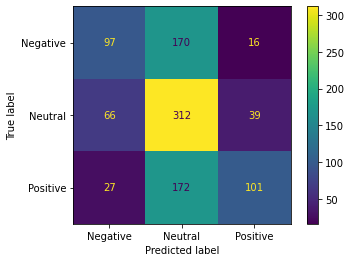

In [50]:
cm = sklearn.metrics.confusion_matrix(true, predicted, labels=["Negative", "Neutral", "Positive"])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["Negative", "Neutral", "Positive"])
disp.plot();

In [51]:
print(f"Recall: Of the {sum(cm[0])} negative examples in the test set, the model correctly labeled {cm[0][0]} ({100*round(cm[0][0]/sum(cm[0]),3)}%).")
print(f"Recall: Of the {sum(cm[1])} neutral examples in the test set, the model correctly labeled {cm[1][1]} ({100*round(cm[1][1]/sum(cm[1]),3)}%).")
print(f"Recall: Of the {sum(cm[2])} positive examples in the test set, the model correctly labeled {cm[2][2]} ({100*round(cm[2][2]/sum(cm[2]),3)}%).")

Recall: Of the 283 negative examples in the test set, the model correctly labeled 97 (34.300000000000004%).
Recall: Of the 417 neutral examples in the test set, the model correctly labeled 312 (74.8%).
Recall: Of the 300 positive examples in the test set, the model correctly labeled 101 (33.7%).


In [52]:
print(f'{cm[0][0]+cm[1][0]+cm[2][0]} examples labeled negative in the test set.')
print(f'The model correctly labeled {cm[0][0]} of them.')
print(f'Precision: The negative predictive value is {round(cm[0][0]/(cm[0][0]+cm[1][0]+cm[2][0]),2)}')
print(f'The proportion of Negative text is {sum(cm[0])/len(eval)}')

190 examples labeled negative in the test set.
The model correctly labeled 97 of them.
Precision: The negative predictive value is 0.51
The proportion of Negative text is 0.283


# Binary classification performance of compositional model
We classify text as positive or negative on the subset of the dataset consisting of such values.

In [53]:
eval_b = wr.s3.read_parquet('s3://ws-10-8-21/eval_b_1000.parquet')

In [54]:
eval_b

,phrase,sentiment,predicted_sentiment
0,In conferences mein khawateen ke infaradi masa...,Positive,Positive
1,Ab inhe aik aur aezaaz hasil hua hai,Positive,Positive
2,Us dauran unhe kae kohna mushq aur tajurbakaa...,Positive,Positive
3,aap zaroor hissa lay.,Positive,Negative
4,ach sory muh seda,Negative,Negative
...,...,...,...
995,Runs banne lage,Positive,Negative
996,"Aglay din aakhir kaar classes, aik adad halo m...",Negative,Negative
997,Masha Allah cute nice Both. Mola Salamt or Kho...,Positive,Positive
998,Bashak mgr ak bat aurat khati wo kon ha jas kh...,Negative,Negative


In [55]:
print(sklearn.metrics.classification_report(eval_b['sentiment'],eval_b['predicted_sentiment'], target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.68      0.73      0.71       462
    Positive       0.75      0.71      0.73       538

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



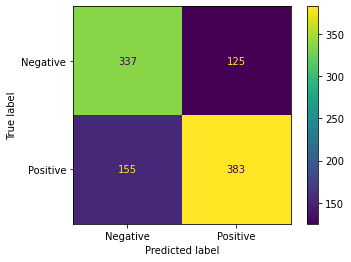

In [56]:
true = eval_b['sentiment']
predicted = eval_b['predicted_sentiment']
cm = sklearn.metrics.confusion_matrix(true, predicted, labels=["Negative", "Positive"])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Negative", "Positive"])
disp.plot();

# Binary classification performance of transformer model
We classify text as positive or negative on the subset of the dataset consisting of such values.

In [57]:
eval_b_HF = wr.s3.read_parquet('s3://ws-10-8-21/eval_b_1000_HF.parquet')

In [58]:
eval_b_HF

,phrase,sentiment,predicted_sentiment
0,bht nikly mere armaan lekin phir b km nikly,Negative,Negative
1,Ferdous ki lawn ap ki hoi,Positive,Positive
2,Mam ap Kay lay.........,Positive,Positive
3,Ya Allah madam farma,Positive,Positive
4,Mghy boht boht boht duaon ke zrort hy,Positive,Negative
...,...,...,...
995,Chha gya mery cheetah,Positive,Positive
996,ya ya.. they have all rights to do that with o...,Positive,Negative
997,Wrna Pakistani dramon mai sivaay rone dhone k ...,Positive,Positive
998,Kal to Maara tha,Negative,Negative


In [59]:
print(sklearn.metrics.classification_report(eval_b_HF['sentiment'],eval_b_HF['predicted_sentiment'], target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.62      0.73      0.67       485
    Positive       0.69      0.57      0.62       515

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.66      0.65      0.65      1000



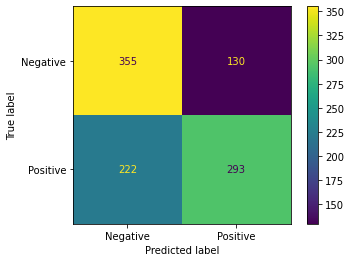

In [60]:
true = eval_b_HF['sentiment']
predicted = eval_b_HF['predicted_sentiment']
cm = sklearn.metrics.confusion_matrix(true, predicted, labels=["Negative", "Positive"])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Negative", "Positive"])
disp.plot();

# Binary classification with the trained transformer model


In [62]:
eval_t_transformer = wr.s3.read_parquet('s3://ws-10-8-21/eval_t_1000_sentiment.parquet')

In [65]:
eval_t_transformer

,phrase,sentiment,predicted_sentiment
0,Sooo soooo nice katni ki h ya,0,0
1,Heheheheheheh yakeen mano mera notification pa...,0,0
2,Qiamat e sughra kay iss manzar kay dauran Ben...,1,0
3,Aur pas chli ja,1,0
4,Duao ki zaroorat dua ki jia ga,0,0
...,...,...,...
995,Allama Raghib Ahsan ne 1931 mein “ all india ...,0,0
996,mjhy ye zyada achy lgy hn unsy... anum,0,0
997,Turbat Se 3 Tashaddud Zada Lashen Baramad,1,0
998,Kash mugha b koi ece trah mot ke khabar dane aata,1,0


In [63]:
eval_t_transformer['predicted_sentiment'].describe()

count    1000.000000
mean        0.014000
std         0.117549
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: predicted_sentiment, dtype: float64

Clearly, as most of the values are 0, training the pre-trained model on the dataset reduced performance. 

# ETL
**All remaining code in the notebook only needs to be ran once.**

We make a directory to store the original data in case the [website](http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set) which is serving it becomes unavailable or updates to a version which is inconsistent with our code.
We download the data with `wget` and add it to the directory.  

In [1]:
%%bash
mkdir original-data
cd original-data
wget http://archive.ics.uci.edu/ml/machine-learning-databases/00458/Roman%20Urdu%20DataSet.csv -O original-data.csv

--2022-01-21 15:00:27--  http://archive.ics.uci.edu/ml/machine-learning-databases/00458/Roman%20Urdu%20DataSet.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1628349 (1.6M) [application/x-httpd-php]
Saving to: ‘original-data.csv’

     0K .......... .......... .......... .......... ..........  3%  330K 5s
    50K .......... .......... .......... .......... ..........  6%  697K 3s
   100K .......... .......... .......... .......... ..........  9%  184M 2s
   150K .......... .......... .......... .......... .......... 12%  303M 2s
   200K .......... .......... .......... .......... .......... 15%  727K 2s
   250K .......... .......... .......... .......... .......... 18% 69.2M 1s
   300K .......... .......... .......... .......... .......... 22% 80.1M 1s
   350K .......... .......... .......... .......... .......... 25%

We load the data into a Pandas dataframe.

Since we were advised not to use GitHub, we'll sync our notebook directory with a new S3 bucket so that we have a backup of the data in case we lose our notebook instance. 

In [4]:
%%bash
aws s3 sync . s3://roman-urdu-nlp/

upload: .ipynb_checkpoints/roman-urdu-nlp-checkpoint.html to s3://roman-urdu-nlp/.ipynb_checkpoints/roman-urdu-nlp-checkpoint.html
upload: ./roman-urdu-nlp.ipynb to s3://roman-urdu-nlp/roman-urdu-nlp.ipynb
upload: ./roman-urdu-nlp.html to s3://roman-urdu-nlp/roman-urdu-nlp.html


Now we load the data into a Pandas dataframe.

In [ ]:
df = pd.read_csv('s3://ws-10-8-21/original-data/original-data.csv', header=None,names=['phrase','sentiment'], index_col=False,dtype={'phrase': 'string','sentiment':'category'}, engine='python')

In [69]:
df.dtypes

phrase         string
sentiment    category
dtype: object

We see below that the dataframe headers and indices are correctly formatted and ready for further preparation.

In [70]:
df.head()

,phrase,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


## Data preparation
We are expecting, according to the [website hosting the data](http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set), there to be three classes, as the site writes "Tagged for Sentiment (Positive, Negative, Neutral)".

We see immediately that there is an issue as there are 4 unique values in sentiment. 

In [71]:
df.describe()

,phrase,sentiment
count,20228,20229
unique,19664,4
top,Good,Neutral
freq,23,8929


Let's fix that. First we need to find these rows. 

In [72]:
df[~df.sentiment.isin(['Neutral','Positive','Negative'])]

,phrase,sentiment
13277,product achi hai but wrong waist size send kar...,Neative


We see there is one row with a mispelled sentiment. Clearly they meant "Negative" here, so we  will update that and keep it.

In [73]:
df.loc[[13277], ['sentiment']] = 'Negative'

Let's check that it is correct now.

In [74]:
df.loc[[13277], ['sentiment']]

,sentiment
13277,Negative


Let's make sure there are now three classes.

In [75]:
df.describe()

,phrase,sentiment
count,20228,20229
unique,19664,3
top,Good,Neutral
freq,23,8929


Another issue is that `phrase` has a count of 20228, while `sentiment` is one higher. Let's fix this.

In [76]:
df[~df['phrase'].notnull()]

,phrase,sentiment
16904,<NA>,Neutral


As we have no idea of knowing what the phrase could have been, we remove this row from the dataset.

In [77]:
df = df.drop([16904])

Make sure it is correct now.

In [78]:
df.describe()

,phrase,sentiment
count,20228,20228
unique,19664,3
top,Good,Neutral
freq,23,8928


Let's check if there are any more `NaN` values. 

In [79]:
df['phrase'].hasnans

False

Since the data is now clean and ready for analysis, let's save a copy to S3 for later access. We save in the Parquet format to ensure the information on data types in the columns is maintained. There is  a tool for doing so directly called AWS Data Wrangler. We use it to save to parquet.

In [80]:
wr.s3.to_parquet(df, 's3://ws-10-8-21/clean-data.parquet')

{'paths': ['s3://ws-10-8-21/clean-data.parquet'], 'partitions_values': {}}

Finally, let's check that it was formatted correctly by loading into a new dataframe. Unexpectedly, if you try to read it with`dfc = pd.read_csv("s3://ws-10-8-21/clean-data.csv")` you will get an error of `ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.` A solution is to change the *engine* to Python. Even then, you will find that the process of loading to and reading from S3 for this dataset in csv format is not idempotent in the sense that each time it will introduce two NaN values into the `phrase` column. We continue then in parquet.

## Loading clean data

In [81]:
dfc = wr.s3.read_parquet('s3://ws-10-8-21/clean-data.parquet')

## Creating training data

In [ ]:
#train_texts =
dfc_b = dfc[dfc['sentiment']!='Neutral'] # binarize
dfc_b['sentiment'] = dfc_b['sentiment'].factorize()[0] #convert to numeric for PyTorch
eval_t_1000 = dfc_b.sample(1000) #sample 1000 for comparison to other models
sample = dfc_b[~dfc_b.index.isin(eval_t_1000.index)] #take complement for train/test data

In [ ]:
wr.s3.to_parquet(eval_t_1000, 's3://ws-10-8-21/eval_t_1000.parquet') # save to S3
wr.s3.to_parquet(sample, 's3://ws-10-8-21/sample.parquet') # save to S3

In [82]:
print(len(sample))
print(len(eval_t_1000))

10300
1000


## Preparing testing data

### Multiclass testing data
We sample 1000 rows from the dataset, apply the multiclass classifier, and write the data to S3.

In [ ]:
%%time
eval = dfc.sample(1000)
eval['predicted_sentiment'] = eval['phrase'].apply(sentiment_roman_urdu)
wr.s3.to_parquet(eval, 's3://ws-10-8-21/eval_1000.parquet') # save to S3

### Binary testing data
We sample 1000 rows from the binarized dataset, apply the binary classifier, and write the data to S3.

In [ ]:
%%time
dfc_b = dfc[dfc['sentiment']!='Neutral']  #remove neutrals from dataset
eval_b = dfc_b.sample(1000)
eval_b['predicted_sentiment'] = eval_b['phrase'].apply(binary_sentiment_roman_urdu)
wr.s3.to_parquet(eval_b, 's3://ws-10-8-21/eval_b_1000.parquet') # save to S3

### Transformer testing data
We sample 1000 rows from the binarized dataset, apply the transformer binary classifier, and write the data to S3.

In [ ]:
%%time
dfc_b = dfc[dfc['sentiment']!='Neutral']  #remove neutrals from dataset
eval_b_HF = dfc_b.sample(1000)
eval_b_HF['predicted_sentiment'] = eval_b_HF['phrase'].apply(binary_sentiment_roman_urdu_HF)
wr.s3.to_parquet(eval_b_HF, 's3://ws-10-8-21/eval_b_1000_HF.parquet') # save to S3

### Trained transformer testing data
We read the evaluation data, then apply the trained transformer model and write the data to S#.

In [ ]:
%%time
eval_t_transformer = wr.s3.read_parquet('s3://ws-10-8-21/eval_t_1000_sentiment.parquet')
eval_t_1000['predicted_sentiment'] = eval_t_1000['phrase'].apply(binary_transformer_sentiment)
wr.s3.to_parquet(eval_t_1000, 's3://ws-10-8-21/eval_t_1000_sentiment.parquet') # save to S3